# In this notebook, we reproduced the results in the bioRxiv paper by Gu et al. following instructions in their provided example notebook.

In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
sys.path.append('../')
import velovae as vv

# Install dependancies

!pip install scvelo <br>
!pip install louvain <br>

# Load Input Data
We demonstrate the full training pipeline using an example dataset from scVelo.

In [2]:
dataset = "Pancreas"
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

Set the parent folder names for saving model parameters, data and figures.

In [3]:
model_path_base = f"checkpoints/{dataset}"
figure_path_base = f"figures/{dataset}"
data_path_base = f"data/{dataset}"

<br><br><br><br><br>
# Preprocessing
We apply exactly the same preprocessing steps as scVelo.
The "preprocess" function performs the following:
1. Cell and gene filtering based on mRNA counts.<br><br>
2. Select a number of genes. By default, it applies the selection method in scVelo to pick highly variable genes. The user can also choose to pick a balanced set of genes by setting <b>"selection_method"</b> to "balanced", meaning that all cell types have the same number of marker genes. Besides these two options, the user can also input a custom list of genes via the argument <b>"genes_retain"</b>.<br><br>
3. Compute a KNN graph based on PCA and average the count data across k neighbors. Dimension of PCA can be set via the argument <b>"npc"</b>. The user can also set the number of neighbors via <b>"n_neighbors"</b>.<br><br>
4. Optionally performs clustering when <b>"perform_clustering"</b> is set to "True".<br><br>
5. Optionally add informative time prior if <b>"tkey"</b> is set to the key in .obs that contains the capture time (either string or float).<br><br>
5. Optionally computes 2D UMAP embedding when <b>"compute_umap"</b> is set to "True".

In [4]:
Ngene = 2000
vv.preprocess(adata, Ngene)

Filtered out 21061 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Pick some genes to plot.

In [5]:
gene_plot = ["Nnat", "Smoc1"]

In [6]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'n_counts', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


# Overview of the dataset on UMAP

saving figure to file figures/Pancreas/umap.png


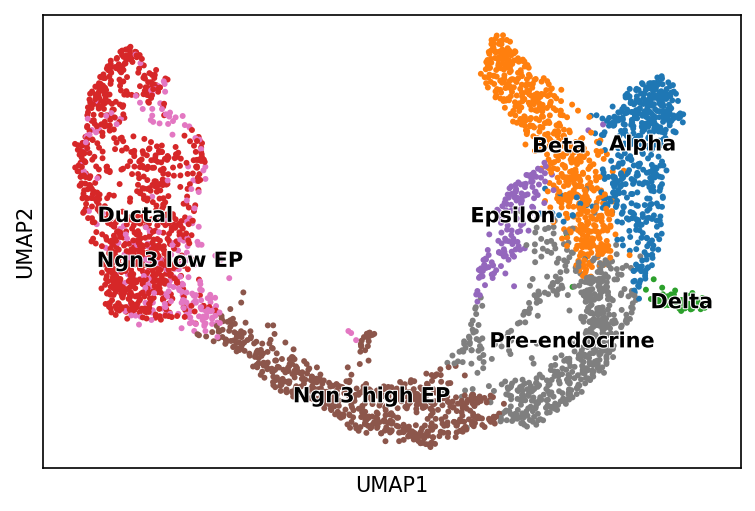

In [149]:
os.makedirs(figure_path_base, exist_ok=True)
colors = vv.plotting.get_colors(len(np.unique(adata.obs['clusters'])), None)
colors = {celltype:colorcode for celltype, colorcode in zip(np.unique(adata.obs['clusters']), colors) }

scv.pl.scatter(adata, basis='umap', save=figure_path_base+"/umap.png", frameon=True, dpi=150, palette=colors, color='clusters', title="")

In [142]:
colors[for i in adata.obs.clusters

index
AAACCTGAGAGGGATA    Pre-endocrine
AAACCTGAGCCTTGAT           Ductal
AAACCTGAGGCAATTA            Alpha
AAACCTGCATCATCCC           Ductal
AAACCTGGTAAGTGGC     Ngn3 high EP
                        ...      
TTTGTCAAGTGACATA    Pre-endocrine
TTTGTCAAGTGTGGCA     Ngn3 high EP
TTTGTCAGTTGTTTGG           Ductal
TTTGTCATCGAATGCT            Alpha
TTTGTCATCTGTTTGT          Epsilon
Name: clusters, Length: 3696, dtype: category
Categories (8, object): ['Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Beta', 'Alpha', 'Delta', 'Epsilon']

<br><br><br><br><br>
# Train a VeloVAE Basic Model
The basic model assumes fixed transcription rates. This serves as a baseline for our method. For real biological data analysis, please consider the complete model or full VB (examples shown in later sections).
***
## Step 1: Define saving paths
We store the figures in "figure_path", model parameters in "model_path" and updated .h5ad file in data_path.

In [8]:
figure_path = figure_path_base+"/VanillaVAE"
model_path = model_path_base+"/VanillaVAE"
data_path = data_path_base

## Step 2: Create a Vanilla VAE object
Mandatory Arguments:
1. <b>adata</b>: anndata object<br><br>
2. <b>tmax</b>: time range. We set it to 20 following the convention from scVelo.<br><br>

Critical Arguments:
1. <b>device</b>: please set to the corresponding cuda device for training if possible.<br><br>
2. <b>hidden_size</b>: a tuple, e.g. (500,250). The two numbers are width of the first and second hidden layers of the encoder network.<br><br>
3. <b>init_method</b>: rate parameter initialization method. By default, the parameter is set to "steady", meaning the steady state model. However, if capture time is available, please consider setting it to "tprior", and the model will be initialized from a time series where the time is approximated by the capture time.<br><br>
4. <b>init_key</b>: key in .obs storing the informative time prior. This is effective only if init_method is set to "tprior".<br><br>
5. <b>tprior</b>: key in .obs storing the informative time prior. <b>This is usually the same key as "init_key", but has a different purpose. This key is used when we compute the KL divergence in ELBO, while "init_key" is used only in initialization.</b>

In [9]:
torch.manual_seed(2022)
np.random.seed(2022)

vanilla_vae = vv.VanillaVAE(adata, tmax=20, device='cpu')

Initialization using the steady-state and dynamical models.
Gaussian Prior.


## Step 3: Mini-batch training
Mandatory Arguments:
1. <b>adata</b>: anndata object
***
Critical Arguments:
1. <b>config</b>: a dictionary containing all hyperparameters. The keys are parameter names (string). Most default hyperparameters achieved consistent performance across different datasets. However, we recommend modifying the following hyperparameters in certain situations:<br><br>
(1) <b>batch_size</b>: set to 128 by default. However, for large datasets, we recommend increasing the batch size accordingly.<br><br>
(2) <b>early_stop</b>: set to 5 by default. This is the number of consecutive epochs when the validation loss decreases by less than some threshold (introduced in the next item), used in early stopping. <br><br>
(3) <b>early_stop_thred</b>: set to $n_{gene}\cdot 10^{-3}$ by default. This is the threshold used in early stopping.<br>

"config" will not be required if you just want the default, as shown in the following line of code.

In [10]:
vanilla_vae.train(adata, plot=True, gene_plot=gene_plot, figure_path=figure_path)

------------------------- Train a Vanilla VAE -------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
Epoch 1: Train ELBO = -4135.023, Test ELBO = -4491.927, 	 Total Time =   0 h :  0 m :  3 s
Epoch 100: Train ELBO = -1651.638, Test ELBO = -1476.996, 	 Total Time =   0 h :  2 m : 29 s
Epoch 200: Train ELBO = 1219.264, Test ELBO = 1243.101, 	 Total Time =   0 h :  4 m : 57 s
Epoch 300: Train ELBO = 1351.322, Test ELBO = 1357.353, 	 Total Time =   0 h :  7 m : 24 s
********* Early Stop Triggered at epoch 330. *********
*********              Finished. Total Time =   0 h :  8 m :  6 s             ********

## Step 4: Save results

In [11]:
vanilla_vae.save_model(model_path, "encoder_vanilla","decoder_vanilla")
vanilla_vae.save_anndata(adata, 'vanilla', data_path, file_name="pancreas_out.h5ad")

***
# Train a VeloVAE Model
This is our full model. In addition to the blocks in the basic model, there is a decoder network producing variable transcription rates.
***
## Step 1: Define saving paths
We store the figures in "figure_path", model parameters in "model_path" and updated .h5ad file in data_path.

In [12]:
figure_path = figure_path_base+"/VAE"
model_path = model_path_base+"/VAE"
data_path = data_path_base

## Step 2: Create a VeloVAE object

Mandatory Arguments:
1. <b>adata</b>: anndata object <br><br>
2. <b>tmax</b>: time range. We set it to 20 following the convention from scVelo.<br><br>
3. <b>dim_z</b>: dimension of the cell state. Here, we use the variable "z" instead of "c" in the paper to follow the convention in the VAE literature.
***
Critical Arguments:
1. <b>device</b>: please set to the corresponding cuda device for training if possible, e.g. 'cuda:0'.<br><br>
2. <b>hidden_size</b>: a tuple, e.g. (500,250,250,500). The first two numbers are width of the first and second hidden layers of the encoder network. The third and fourth numbers are width of the first and second hidden layers of the decoder network. Our decoder network is usually a mirror image of the encoder.<br><br>
3. <b>init_method</b>: rate parameter initialization method. By default, the parameter is set to "steady", meaning the steady state model. However, if capture time is available, please consider setting it to "tprior", and the model will be initialized from a time series where the time is approximated by the capture time.<br><br>
4. <b>init_key</b>: key in .obs storing the informative time prior. This is effective only if "init_method" is set to "tprior".<br><br>
5. <b>tprior</b>: key in .obs storing the informative time prior. <b>This is usually the same key as "init_key", but has a different purpose. This key is used when we compute the KL divergence in ELBO, while "init_key" is used only in initialization.</b><br><br>
6. <b>init_ton_zero</b>: set to True by default. If set to "True", the switch-on time of each gene is 0. We recommend setting it to "False" if the capture time is available and this worked better empirically.

In [13]:
torch.manual_seed(2022)
np.random.seed(2022)
vae = vv.VAE(adata, tmax=20, dim_z=5, device='cpu')

Initialization using the steady-state and dynamical models.
Gaussian Prior.


## Step 3: Mini-batch training
Mandatory Arguments:
1. <b>adata</b>: anndata object
***
Critical Arguments:
This will not be required if you just want the default, as shown in the following line of code.<br>
1. <b>config</b>: a dictionary containing all hyperparameters. The keys are parameter names (string). Most default hyperparameters achieved consistent performance across different datasets. However, we recommend modifying the following hyperparameters in certain situations:<br><br>
(1) <b>batch_size</b>: set to 128 by default. However, for large datasets, we recommend increasing the batch size accordingly.<br><br>
(2) <b>early_stop</b>: set to 5 by default. This is the number of consecutive epochs when the validation loss decreases by less than some threshold (introduced in the next item), used in early stopping. <br><br>
(3) <b>early_stop_thred</b>: set to $n_{gene}\cdot 10^{-3}$ by default. This is the threshold used in early stopping.<br><br>
(4) <b>n_neighbors</b>: set to 10 by default. This is the number of neighbors when we estimate the initial condition by averaging u,s in a time window.<br><br>
(5) <b>dt</b>: set to $(0.03,0.06)$ by default. This is used to pick the time window during recalculating the initial condition for each cell. For example, let $t$ be a cell time and $\Delta_t$ be the time range across all cells. Then the time window will be $[t-0.06\Delta_t, t-0.03\Delta_t]$

In [14]:
vae.train(adata, gene_plot=gene_plot, plot=True, figure_path=figure_path, embed="umap")

--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
Epoch 1: Train ELBO = -12961.801, Test ELBO = -231129.766, 	 Total Time =   0 h :  0 m :  3 s
Epoch 100: Train ELBO = 794.399, Test ELBO = 803.284, 	 Total Time =   0 h :  3 m :  7 s
Epoch 200: Train ELBO = 1624.300, Test ELBO = 1635.045, 	 Total Time =   0 h :  6 m :  9 s
Epoch 300: Train ELBO = 1952.917, Test ELBO = 1954.591, 	 Total Time =   0 h :  8 m : 56 s
Epoch 400: Train ELBO = 2079.960, Test ELBO = 2063.556, 	 Total Time =

## Step 4: Save results

In [15]:
vae.save_model(model_path, 'encoder_vae', 'decoder_vae')
vae.save_anndata(adata, 'vae', data_path, file_name="pancreas_out.h5ad")

<br><br><br><br><br>
# Train a VeloVAE (Full VB) Model
The full VB model is a slight extension of VeloVAE by treating the rate parameters as random variables. Model usage is the same as VeloVAE.
***
## Step 1: Define saving paths
We store the figures in "figure_path", model parameters in "model_path" and updated .h5ad file in data_path.

In [16]:
figure_path = figure_path_base+"/FullVB"
model_path = model_path_base+"/FullVB"
data_path = data_path_base

## Step 2: Create a full VB object
For input arguments, we refer to the module for VeloVAE.

In [17]:
torch.manual_seed(2022)
np.random.seed(2022)
full_vb = vv.VAEFullVB(adata, tmax=20, dim_z=5, device='cuda:0')

Initialization using the steady-state and dynamical models.
Gaussian Prior.


## Step 3: Mini-batch training
The only additional hyperparameter for the full VB is <b>"kl_param"</b>, the coefficient of KL divergence between the rate parameter distributions. It's set to 1.0 by default.<br>
All other input arguments and hyperparameters in config are the same as VeloVAE.

In [18]:
full_vb.train(adata, plot=True, gene_plot=gene_plot, figure_path=figure_path, embed="umap")

--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21, test iteration: 40
Epoch 1: Train ELBO = -12638.800, Test ELBO = -230957.172, 	 Total Time =   0 h :  0 m :  4 s
Epoch 100: Train ELBO = 836.583, Test ELBO = 747.206, 	 Total Time =   0 h :  2 m : 47 s
Epoch 200: Train ELBO = 1606.315, Test ELBO = 1577.980, 	 Total Time =   0 h :  5 m : 32 s
Epoch 300: Train ELBO = 1930.151, Test ELBO = 1891.874, 	 Total Time =   0 h :  8 m : 17 s
Epoch 400: Train ELBO = 2048.866, Test ELBO = 2009.149, 	 Total Time =

## Step 4: Save results

In [19]:
full_vb.save_model(model_path, "encoder_fullvb","decoder_fullvb")
full_vb.save_anndata(adata, 'fullvb', data_path, file_name="pancreas_out.h5ad")

<br><br><br><br><br>
# (Optional) Train a Branching ODE Model
The branching ODE is a lumped-element model for VeloVAE. It treats each cell type separately and learns type-specific rate parameters. Please train VeloVAE or Full VB first before training this model.
## Step 1: Define saving paths
We store the figures in "figure_path", model parameters in "model_path" and updated .h5ad file in data_path.

In [20]:
figure_path = figure_path_base+"/BrODE"
model_path = model_path_base+"/BrODE"
data_path = data_path_base

## Step 2: Create a Branching ODE object
To create a Branching ODE object, we need to pass the following arguments:<br>
1. AnnData object with trained parameters stored inside (via saveAnnData)<br><br>
2. Key in .obs storing cell types, e.g. "clusters".<br><br>
3. Key in .obs storing inferred cell time, e.g. "fullvb_time".<br><br>
4. Key in .obsm storing inferred cell latent state, e.g. "fullvb_z".<br><br>
5. (Optional) Parameters for transition graph computation. The transition graph is computed by first picking k nearest neighbors in a time window as the progenitor cells. Then, it computes the frequency of cell type transition and builds a weighted graph. Finally, it applies the Chu-Liu/Edmonds algorithm to find a maximum spanning tree. This parameter is a dictionary with three keys:<br><br>
    (1) $\mathbf{dt}$: a tuple of time window coefficient, e.g. (0.01, 0.05). In this example, for any cell with time t, its progenitor cell will be picked in the time window $[t-0.05\cdot \Delta_t, t-0.01\cdot \Delta_t]$, where $\Delta_t = t_{max}-t_{min}$<br><br>
    (2)$\mathbf{k}$: number of progenitor cells in the time window<br><br>
    (3)<b>n_par</b>: number of potential parent cell type. This is used in graph pruning. Usually set to 2 or 3 to speed up <br><br>computation.

In [21]:
torch.manual_seed(2022)
np.random.seed(2022)
brode = vv.BrODE(adata, "clusters", "fullvb_time", "fullvb_z", graph_param={"dt":(0.01,0.05), "k":5, "n_par":2})

Graph Partition
Number of partitions:  1
Computing type-to-type transition probability
Obtaining the MST in each partition
Initialization using type-specific dynamical model.


## Step 3: Mini-batch Training

In [22]:
brode.train(adata, "fullvb_time", "clusters", plot=True, gene_plot=gene_plot, figure_path=figure_path)

------------------------ Train a Branching ODE ------------------------
               Alpha  Beta  Delta  Ductal  Epsilon  Ngn3 high EP  Ngn3 low EP  Pre-endocrine
Alpha            0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Beta             0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Delta            0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Ductal           0.0   0.0    0.0     1.0      0.0           0.0          0.0            0.0
Epsilon          0.0   0.0    0.0     0.0      0.0           0.0          0.0            1.0
Ngn3 high EP     0.0   0.0    0.0     0.0      0.0           0.0          1.0            0.0
Ngn3 low EP      0.0   0.0    0.0     1.0      0.0           0.0          0.0            0.0
Pre-endocrine    0.0   0.0    0.0     0.0      0.0           1.0          0.0            0.0
*********        Creating Training/Validation Datasets        *********
*********          

## Step 4: Save results

In [23]:
brode.save_model(model_path, "brode")
brode.save_anndata(adata, 'brode', data_path, file_name="pancreas_out.h5ad")

In [24]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'n_counts', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'vanilla_time', 'vanilla_std_t', 'vae_time', 'vae_std_t', 'vae_t0', 'fullvb_time', 'fullvb_std_t', 'fullvb_t0', 'partition', 'brode_time', 'brode_label'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'vanilla_alpha', 'vanilla_beta', 'vanilla_gamma', 'vanilla_toff', 'vanilla_ton', 'vanilla_scaling', 'vanilla_sigma_u', 'vanilla_sigma_s', 'vae_alpha', 'vae_beta', 'vae_gamma', 'vae_ton', 'vae_scaling', 'vae_sigma_u', 'vae_sigma_s', 'vae_likelihood', 'fullvb_logmu_alpha', 'fullvb_logmu_beta', 'fullvb_logmu_gamma', 'fullvb_logstd_alpha', 'fullvb_logstd_beta', 'fullvb_logstd_gamma', 'fullvb_ton', 'fullvb_scaling', 'fullvb_sigma_u', 'fullvb_sigma_s', 'fullvb_likelihood', 'brode_scaling', 'brode_sigma_u', 'brode_sigma_s'
    uns

<br><br><br><br><br>
# Post Analysis
## Compute the Metrics and Plot the Genes
Use the built-in analysis function of the velovae package
***
Mandatory Arguments:
1. <b>adata</b>: anndata object<br><br>
2. <b>test_id</b>: name of the test. Used for storing the figures.<br><br>
3. <b>methods</b>: name of the methods. Should be a list containing one or multiple of the following: "scVelo", "Vanilla VAE", "VeloVAE", "Full VB".<br><br>
4. <b>keys</b>: list of key names corresponding to each method. This is used to extract all relevant quantities (latent variables, rate parameters). For example, when we pick VeloVAE as the method, the corresponding key is "vae". The rate parameters were previously stored as "vae_alpha", "vae_beta", "vae_gamma" in .var when we called the 'save_anndata' function. 
***
Critical Arguments:
1. <b>compute_metrics</b>: whether to compute the performance metrics. Should be set to False if you only want figures.<br><br>
2. <b>genes</b>: genes to plot.<br><br>
3. <b>plot_type</b>: list of plot type names. Should contain zero or more from the following: "phase", "signal", "time", "cluster".<br><br>
4. <b>grid_size</b>: tuple, e.g. (M,N). The signal plot of genes will be in a single figure containing a grid of subplots. The grid has M rows and N columns. If $M\times N<n_{gene}$, multiple figures will be generated.

In [25]:
methods = ['Vanilla VAE', 'VeloVAE']
keys = ['vanilla', 'vae']
grid_size = (1,2)
plot_type = ["phase","signal","time"]
vv.post_analysis(adata, 
                 test_id="pancreas",
                 methods=methods, 
                 keys=keys,
                 compute_metrics=True,
                 genes=gene_plot, 
                 plot_type=plot_type, 
                 embed="umap", 
                 grid_size=grid_size, 
                 save_path=figure_path_base)

---     Post Analysis     ---
Dataset Size: 3696 cells, 2000 genes
           Vanilla VAE    VeloVAE
MSE Train      10.1938     2.8248
MAE Train       0.4279     0.2261
MSE Test        9.4168     2.7753
MAE Test        0.4207     0.2276
LL Train     1347.6695  2030.0446
LL Test      1373.2067  2015.8308
---   Plotting  Results   ---


,Vanilla VAE,VeloVAE
MSE Train,10.1938,2.8248
MAE Train,0.4279,0.2261
MSE Test,9.4168,2.7753
MAE Test,0.4207,0.2276
LL Train,1347.6695,2030.0446
LL Test,1373.2067,2015.8308


## Cell Time and State Uncertainty
We can call plot_state_var and plot_time_var directly from the velovae.plotting module.

In [26]:
key = "fullvb"
basis = "umap"

# Figure S5(a) cell state uncertainty

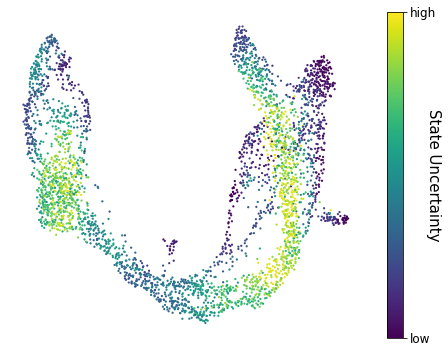

In [27]:
std_z = adata.obsm[f"{key}_std_z"]
z = adata.obsm[f"{key}_z"]
X_embed = adata.obsm[f"X_{basis}"]
#vv.plotting.plot_state_var(std_z, X_embed, z, save=f"figures/Pancreas/pancreas_state_var.png")
vv.plotting.plot_state_var(std_z, X_embed, z)

# Figure S6 Cell time uncertainty

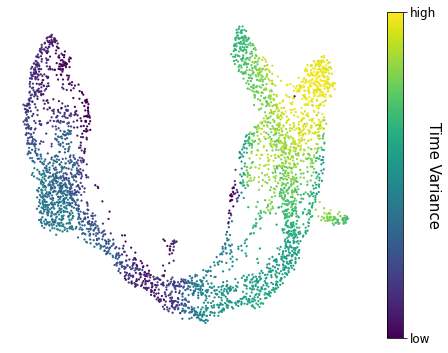

In [28]:
t = adata.obs["fullvb_time"].to_numpy()
std_t = adata.obs["fullvb_std_t"].to_numpy()
X_embed = adata.obsm[f"X_{basis}"]
vv.plotting.plot_time_var(std_t, X_embed, t, save=None)

## Figure S3 Cell time on UMAP 3D

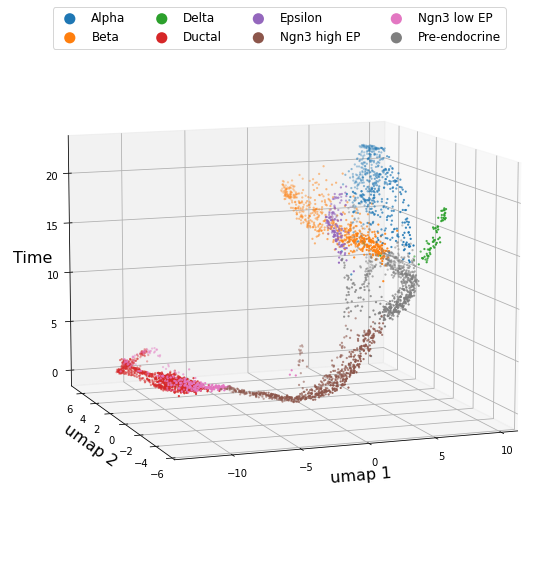

In [29]:

vv.plotting.plot_trajectory_3d(adata.obsm['X_umap'], adata.obs['fullvb_time'].to_list(), adata.obs['clusters'], figsize=(10,8), angle=(10, 250))

## Velocity Stream Plot (Figure 2(c))

computing velocity graph (using 1/16 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:31) --> added 
    'vanilla_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vanilla_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Pancreas/Pancreas_velocity_vanilla.png


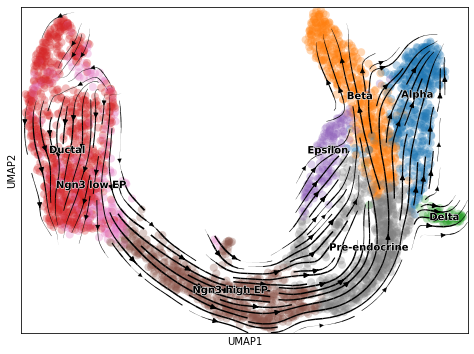

In [157]:
key = 'vanilla'
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', title="", figsize=(8,6), frameon=True, \
    save=f'{figure_path_base}/{dataset}_velocity_{key}.png', palette=colors, color='clusters')

computing velocity graph (using 1/16 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:31) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Pancreas/Pancreas_velocity_vae.png


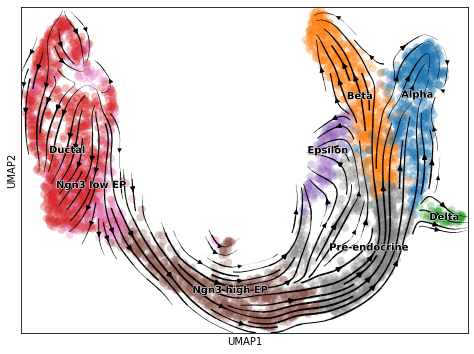

In [158]:
key = 'vae'
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', title="", figsize=(8,6), frameon=True, \
    save=f'{figure_path_base}/{dataset}_velocity_{key}.png', palette=colors, color='clusters')

computing velocity graph (using 1/16 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:32) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Pancreas/Pancreas_velocity_fullvb.png


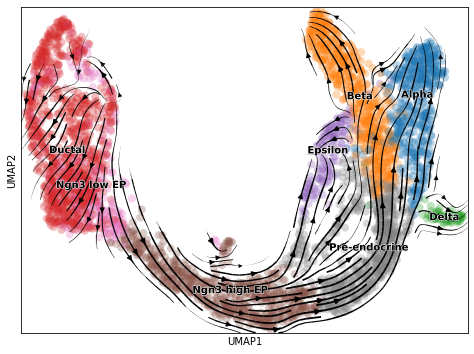

In [156]:
key = 'fullvb'
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', title="", figsize=(8,6), frameon=True, \
    save=f'{figure_path_base}/{dataset}_velocity_{key}.png', palette=colors, color='clusters')

In [33]:
adata.write_h5ad(data_path_base+"/pancreas_out.h5ad")

# Note since the program does not compute du/dt, the arrows only represent ds/dt.

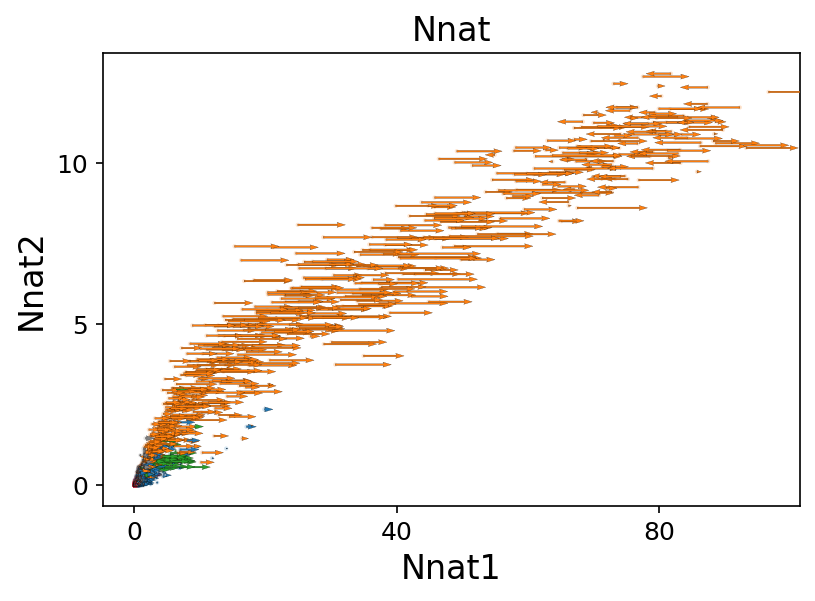

In [154]:
key = 'vae'
scv.pl.velocity_embedding(adata, vkey=f'{key}_velocity', basis='Nnat', palette=colors, color='clusters',
                          fontsize=16, frameon=True, legend_loc='none', dpi=150)

# Gene velocity plots Figure 2(c)

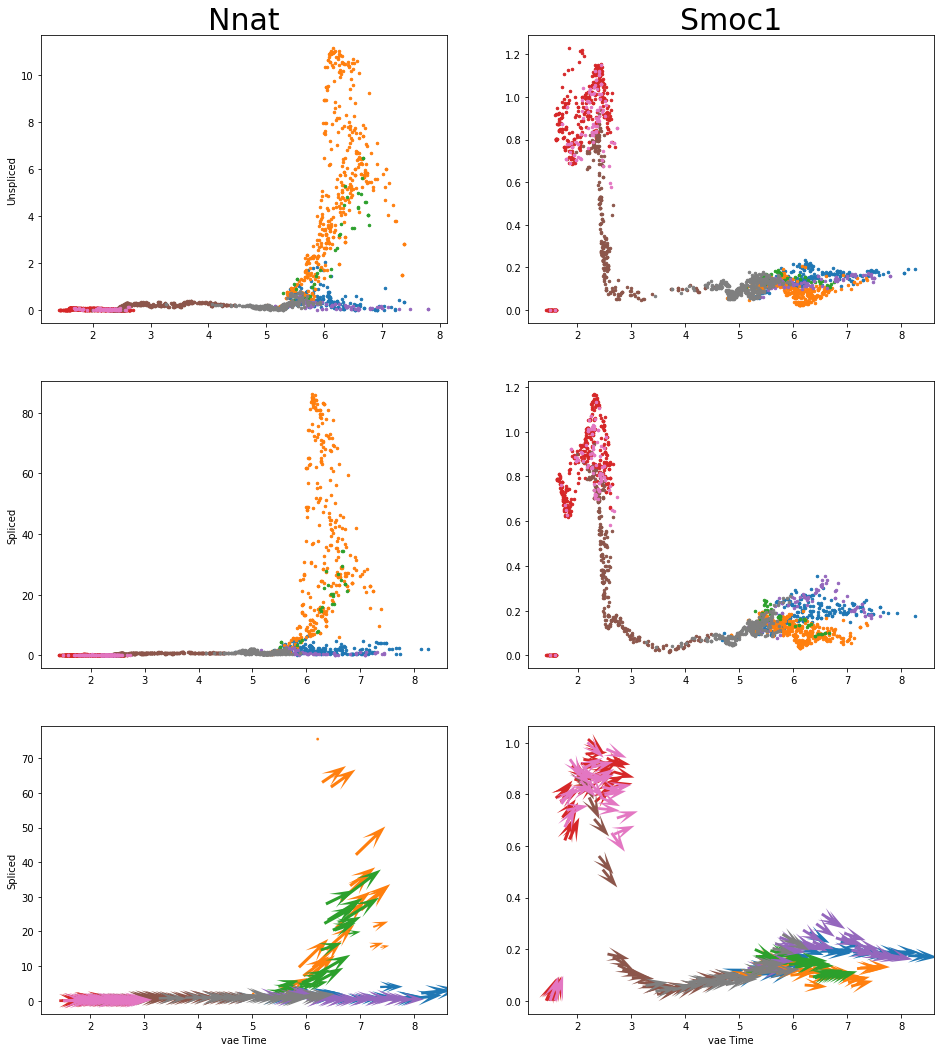

In [112]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,18), nrows=3, ncols=2)
for i in range(len(gene_plot)):
    gene = adata.var.index == gene_plot[i]
    method='vae'
    t=adata.obs[f'{method}_time']
    u=adata.layers[f'{method}_u0'][:, gene]
    s=adata.layers[f'{method}_s0'][:, gene]
    v=adata.layers[f'{method}_velocity'][:,gene]
    u_pred = adata.layers[f'{method}_uhat'][:, gene]
    s_pred = adata.layers[f'{method}_shat'][:, gene]

    cell_labels = adata.obs['clusters']
    legends = np.unique(cell_labels)
    labels = cell_labels.replace(legends, value=range(len(legends)))

    vv.plotting.plot_sig_axis(ax[0,i], t, u, labels=labels, title= gene_plot[i], legends=legends)
    vv.plotting.plot_sig_axis(ax[1,i], t, s, labels=labels, legends=legends)
    vv.plotting.plot_vel_axis(ax=ax[2,i], t=t, x=s, v=v, labels=labels, legends=np.unique(cell_labels))

    ax[2,i].set_xlabel(f'{method} Time')
    ax[0,0].set_ylabel('Unspliced')
    ax[1,0].set_ylabel('Spliced')
    ax[2,0].set_ylabel('Spliced')

plt.show()

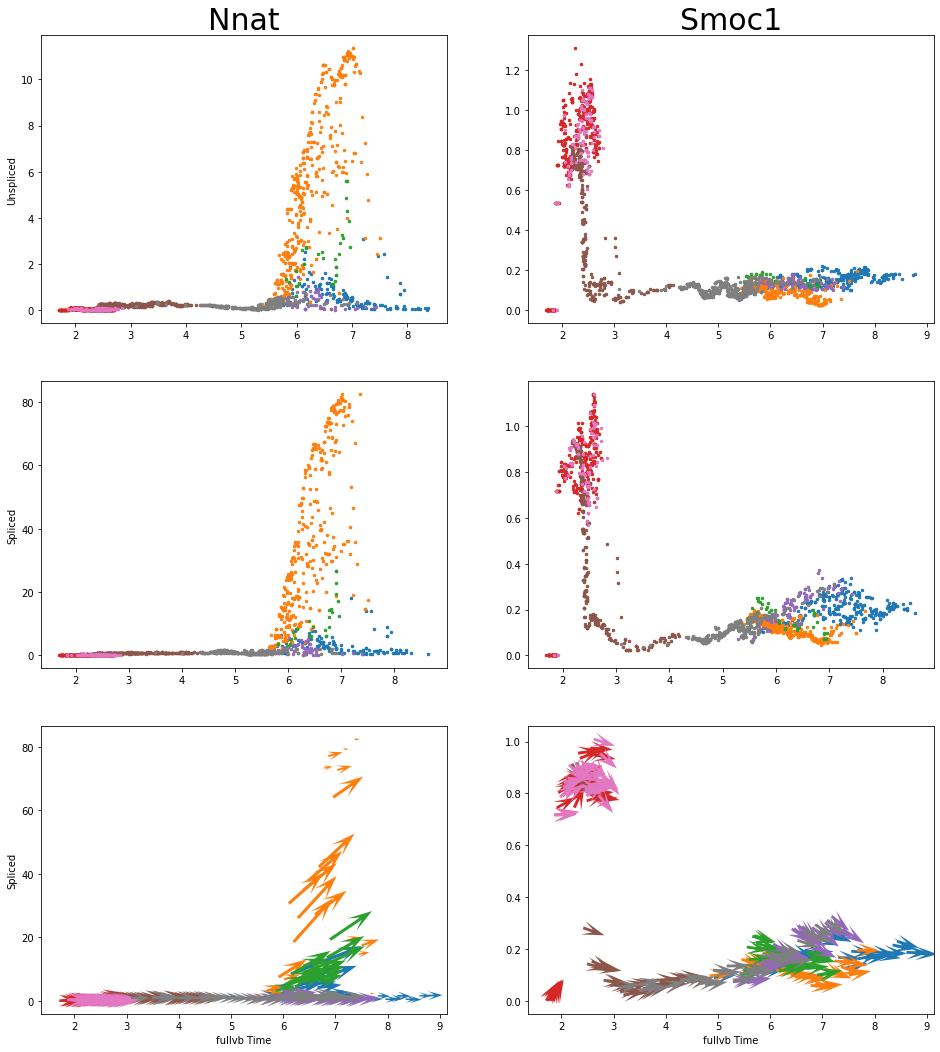

In [113]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,18), nrows=3, ncols=2)
for i in range(len(gene_plot)):
    gene = adata.var.index == gene_plot[i]
    method='fullvb'
    t=adata.obs[f'{method}_time']
    u=adata.layers[f'{method}_u0'][:, gene]
    s=adata.layers[f'{method}_s0'][:, gene]
    v=adata.layers[f'{method}_velocity'][:,gene]
    u_pred = adata.layers[f'{method}_uhat'][:, gene]
    s_pred = adata.layers[f'{method}_shat'][:, gene]

    cell_labels = adata.obs['clusters']
    legends = np.unique(cell_labels)
    labels = cell_labels.replace(legends, value=range(len(legends)))

    vv.plotting.plot_sig_axis(ax[0,i], t, u, labels=labels, title= gene_plot[i], legends=legends)
    vv.plotting.plot_sig_axis(ax[1,i], t, s, labels=labels, legends=legends)
    vv.plotting.plot_vel_axis(ax=ax[2,i], t=t, x=s, v=v, labels=labels, legends=np.unique(cell_labels))

    ax[2,i].set_xlabel(f'{method} Time')
    ax[0,0].set_ylabel('Unspliced')
    ax[1,0].set_ylabel('Spliced')
    ax[2,0].set_ylabel('Spliced')

plt.show()

<br><br><br>
# Branching genes BrODE plots Figure 3

In [161]:
branching_gene = ['Ppp1r1a', 'Rnf130', '1500009L16Rik']

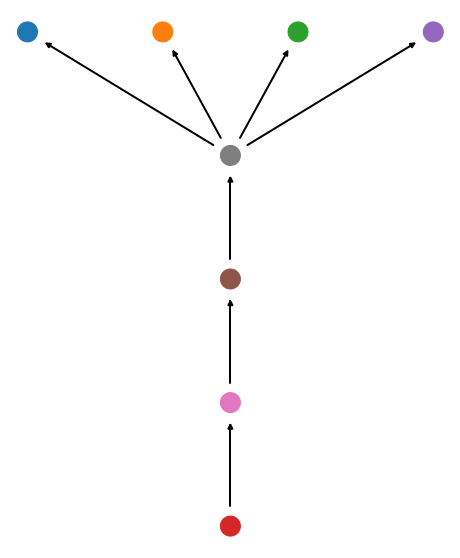

In [165]:
vv.plotting.plot_transition_graph(adata)

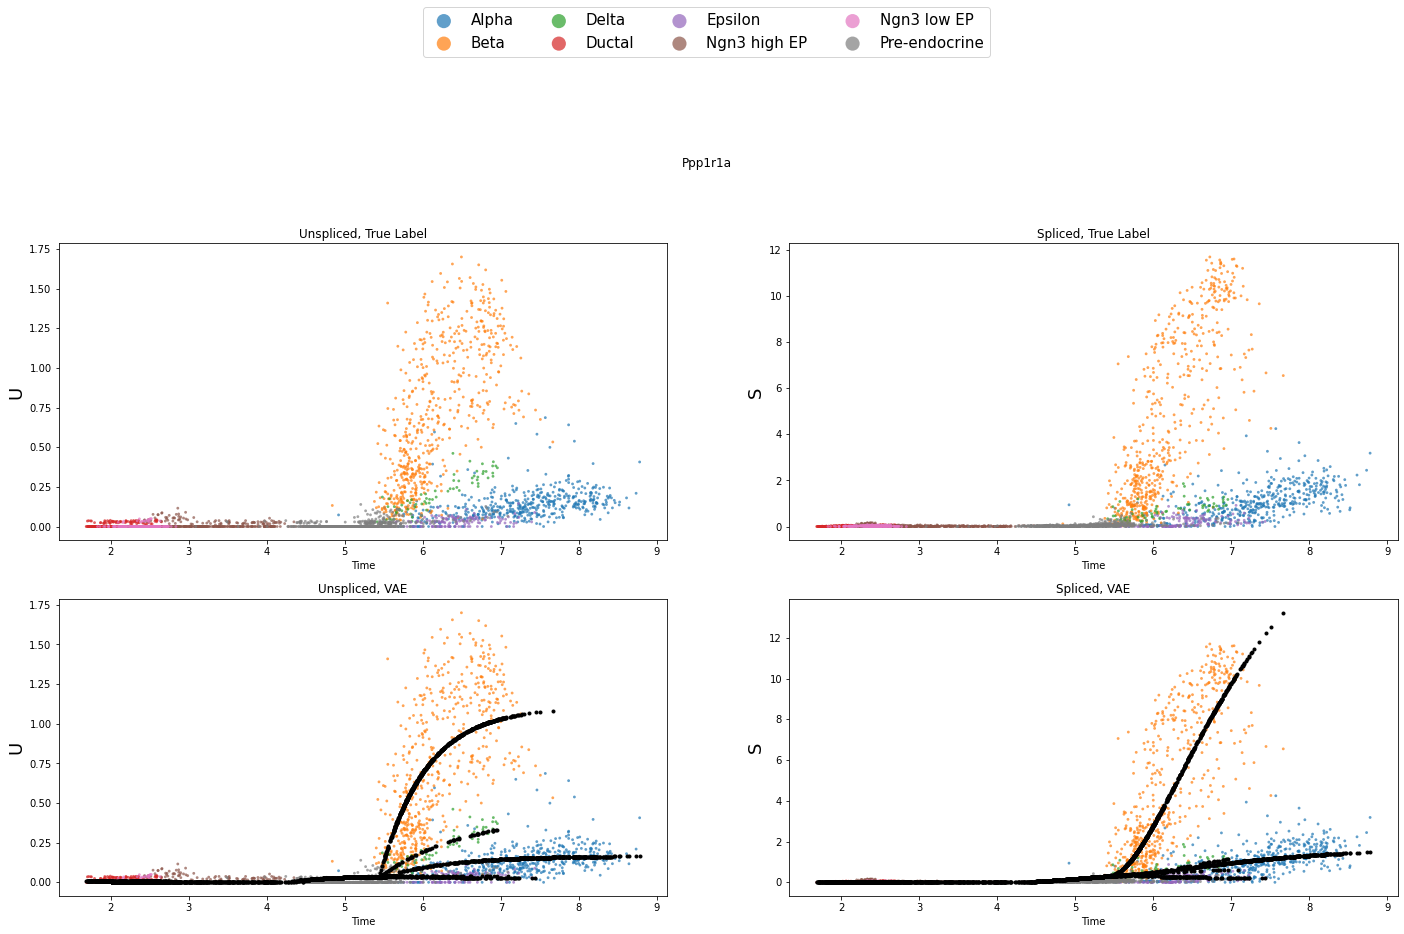

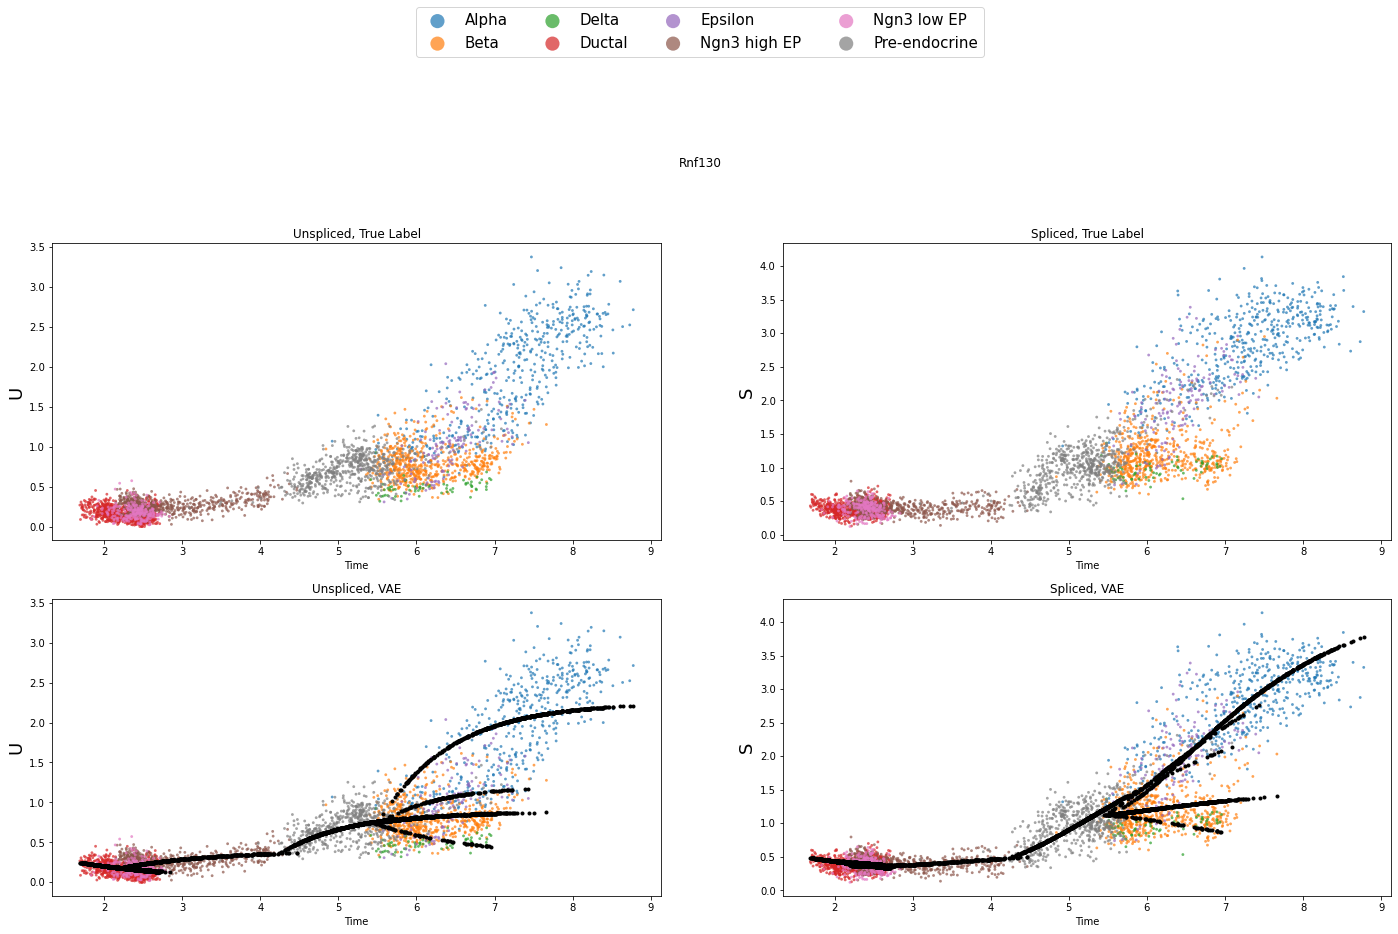

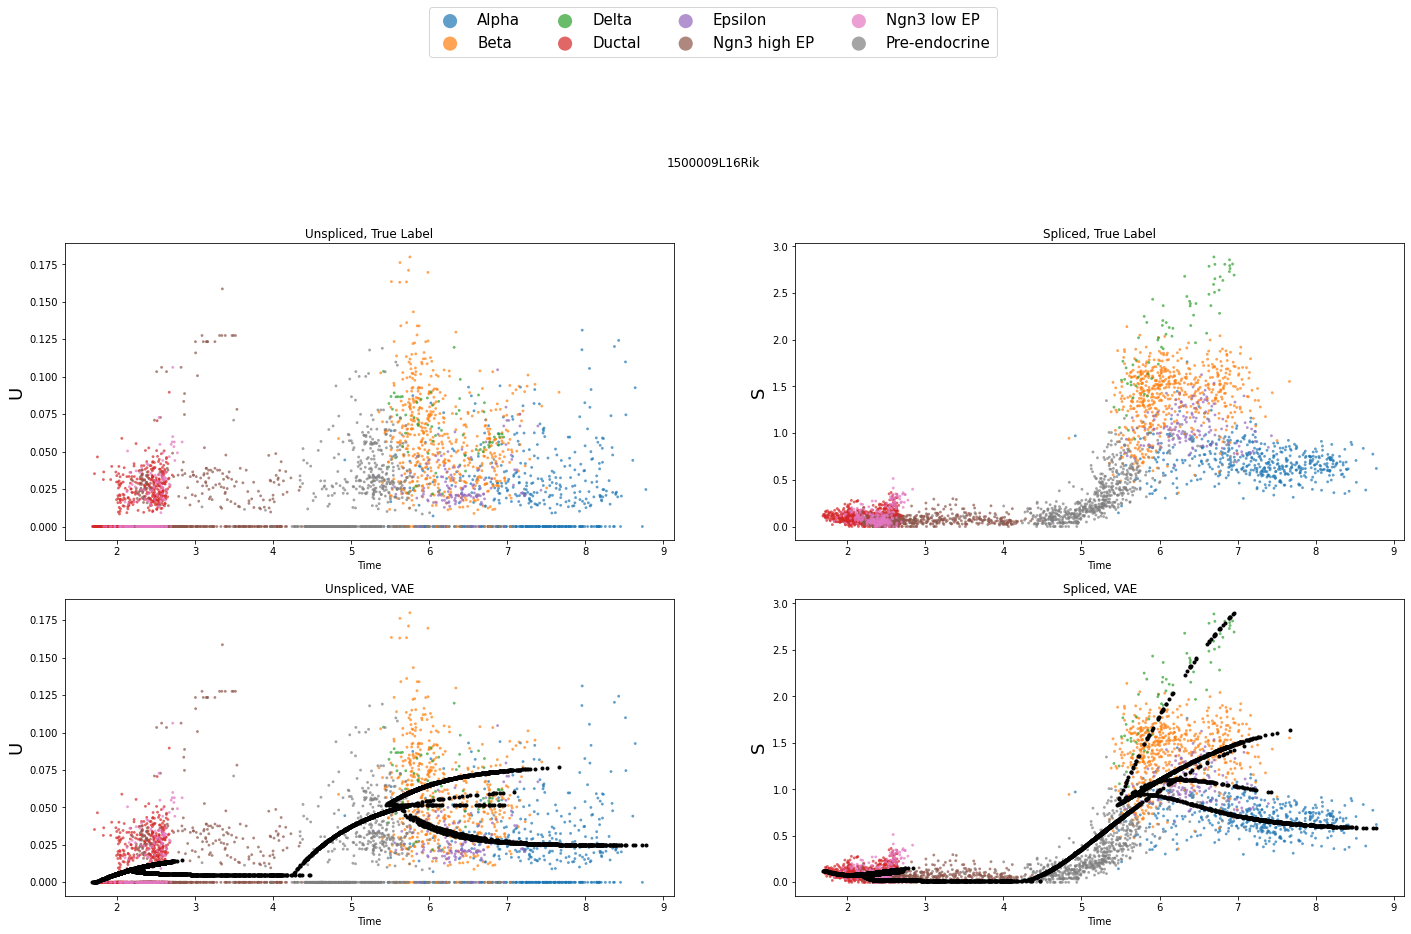

In [216]:
for i in range(len(branching_gene)):
    gene = adata.var.index == branching_gene[i]
    method='brode'
    t=adata.obs[f'{method}_time']
    u=adata.layers['Mu'][:, gene]
    s=adata.layers['Ms'][:, gene]

    v=adata.layers[f'{method}_velocity'][:,gene]
    u_pred = adata.layers[f'{method}_uhat'][:, gene]
    s_pred = adata.layers[f'{method}_shat'][:, gene]

    cell_labels = adata.obs['clusters']

    vv.plotting.plot_sig(t.to_numpy(), u, s, u_pred, s_pred, cell_labels=cell_labels.to_numpy(), title=branching_gene[i])

plt.show()

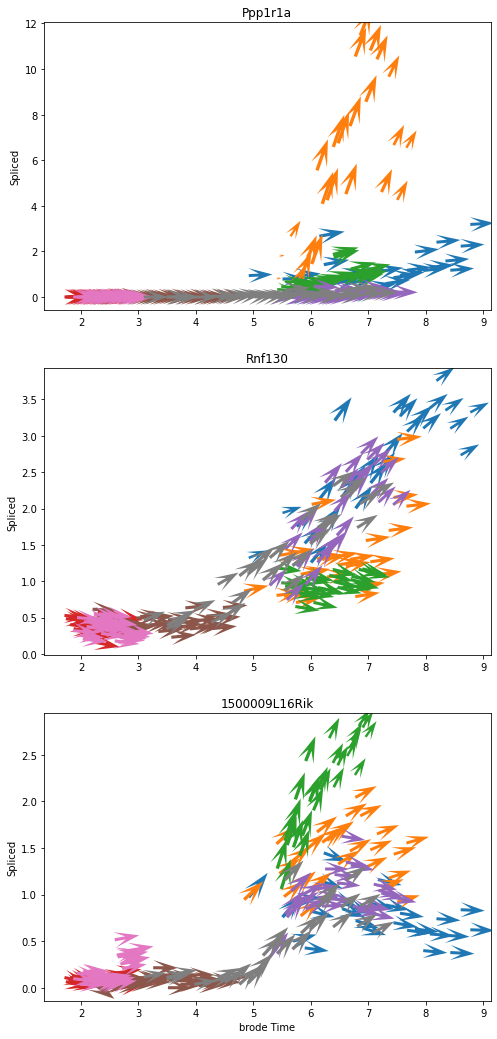

In [221]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,18), nrows=3, ncols=1)
for i in range(len(branching_gene)):
    gene = adata.var.index == branching_gene[i]
    method='brode'
    t=adata.obs[f'{method}_time']
    u=adata.layers['Mu'][:, gene]
    s=adata.layers['Ms'][:, gene]
    v=adata.layers[f'{method}_velocity'][:,gene]
    
    cell_labels = adata.obs['clusters']
    legends = np.unique(cell_labels)
    labels = cell_labels.replace(legends, value=range(len(legends)))

    vv.plotting.plot_vel_axis(ax=ax[i], t=t, x=s, v=v, labels=labels, legends=np.unique(cell_labels))

    ax[2].set_xlabel(f'{method} Time')
    ax[i].set_ylabel('Spliced')
    ax[i].set_title(branching_gene[i])

plt.show()

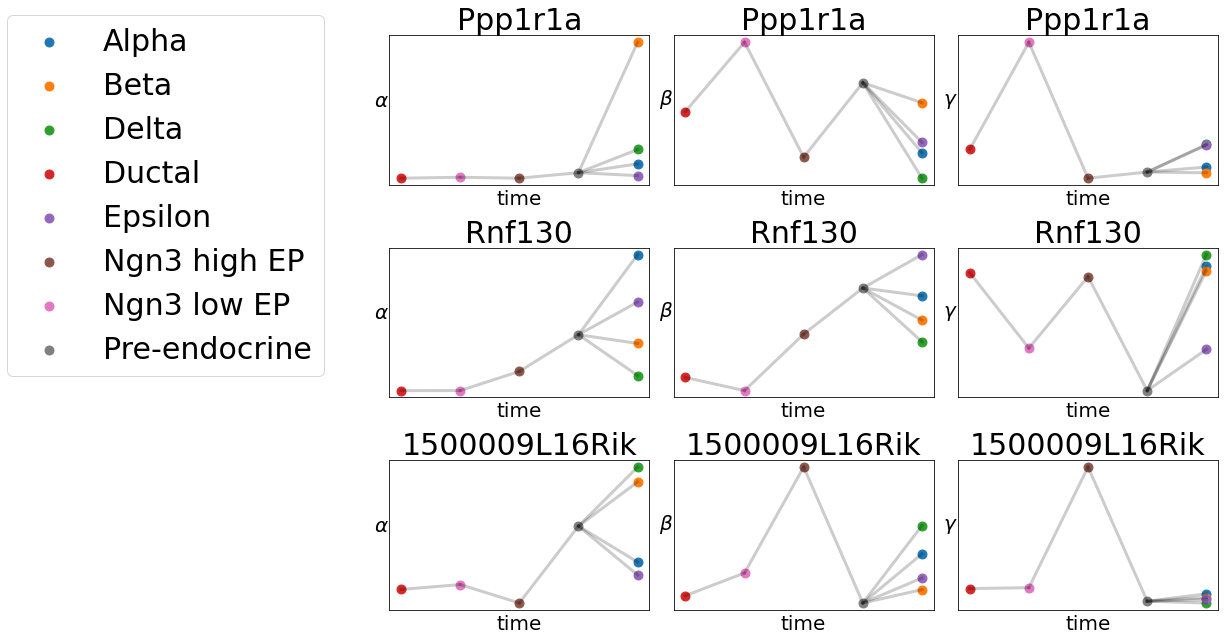

In [234]:
vv.plotting.plot_rate_grid(adata, 'brode', branching_gene, 3, 1, figname=None )